# Notebook Imports

In [193]:
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split

%matplotlib inline

# Constants

In [235]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NOSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NOSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FIFLE = 'SpamData/01_Processing/word-by-id.csv'
TRAIN_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

# Reading Files

In [16]:

stream = open(EXAMPLE_FILE,encoding='latin-1')

#Getting email body
is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True
        
stream.close()
        
email_body = '\n'.join(lines)
print(email_body)





Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [17]:
def generate_squares(n):
    for i in range(n):
        yield i**2

In [18]:
for i in generate_squares(3):
    print(i,end='->')

0->1->4->

# Email body extraction

In [19]:
def email_body_generator(path):
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            file_path = join(root,file_name)
            stream = open(file_path,encoding='latin-1')

            #Getting email body
            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            yield file_name, email_body


            

In [20]:
def df_from_directry(path, classification):
    rows = []
    row_names = []
    for file_name,email_body in email_body_generator(path):
        rows.append({'MESSAGE':email_body,'CATEGORY':classification})
        row_names.append(file_name)
    return pd.DataFrame(rows,index=row_names)
        

In [21]:
#Get the data from emails
spam_emails = df_from_directry(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directry(SPAM_2_PATH,SPAM_CAT))
ham_emails = df_from_directry(EASY_NOSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directry(EASY_NOSPAM_2_PATH, HAM_CAT))


In [22]:
data = pd.concat([spam_emails,ham_emails])

In [23]:
data.shape

(5799, 2)

# Data Cleaning: Checking for missing values

In [24]:
#Chcking for null values
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5799 entries, 00249.5f45607c1bffe89f60ba1ec9f878039a to 00747.352d424267d36975a7b40b85ffd0885e
Data columns (total 2 columns):
MESSAGE     5799 non-null object
CATEGORY    5799 non-null int64
dtypes: int64(1), object(1)
memory usage: 135.9+ KB


In [25]:
#Checking for empty emails
(data.MESSAGE.str.len() == 0).any()

True

In [26]:
(data.MESSAGE.str.len() == 0).sum()

3

## Locate empty emails

In [27]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

## Remove sistem entries on data (cmds)

In [28]:
data = data.drop(['cmds'])

In [29]:
#Checking for empty emails
(data.MESSAGE.str.len() == 0).sum()

0

## Add Document ID to track email in dataset

In [30]:
document_ids = range(0,len(data.index))

In [31]:
document_ids

range(0, 5796)

In [32]:
data['DOC_ID'] = document_ids

In [33]:
#Set the file names as the index
data['FILE_NAME'] = data.index

## Save to file with pandas

In [34]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualise (Pie Charts)

In [35]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [36]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

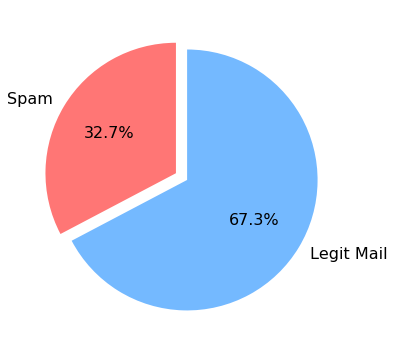

In [37]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam,amount_of_ham]
custom_colors = ['#ff7675','#74b9ff']


plt.figure(figsize=(9,6))
plt.pie(sizes, labels=category_names,textprops={'fontsize':16},startangle=90,autopct='%1.1f%%'
        ,colors=custom_colors, explode=[0,0.1])
plt.show()

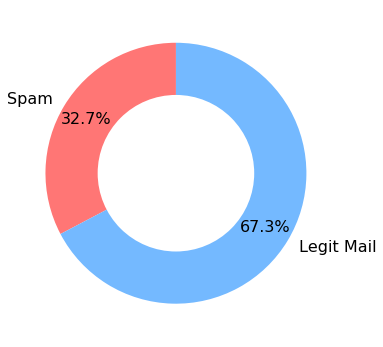

In [38]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam,amount_of_ham]
custom_colors = ['#ff7675','#74b9ff']



plt.figure(figsize=(9,6))
plt.pie(sizes, labels=category_names,textprops={'fontsize':16},startangle=90,autopct='%1.1f%%'
        ,colors=custom_colors,pctdistance=0.8)

#Draw circle
center_circle = plt.Circle((0,0),radius=0.6,fc='white')
plt.gca().add_artist(center_circle)

plt.show()

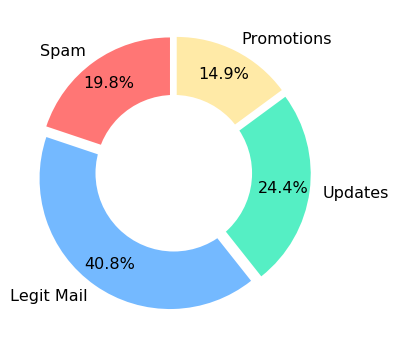

In [39]:
category_names = ['Spam', 'Legit Mail','Updates','Promotions']
sizes = [amount_of_spam,amount_of_ham,2334,1424]
custom_colors = ['#ff7675','#74b9ff','#55efc4','#ffeaa7']
offset = [0.05,0.05,0.05,0.05]


plt.figure(figsize=(9,6))
plt.pie(sizes, labels=category_names,textprops={'fontsize':16},startangle=90,autopct='%1.1f%%'
        ,colors=custom_colors,pctdistance=0.8,explode=offset)

#Draw circle
center_circle = plt.Circle((0,0),radius=0.6,fc='w')
plt.gca().add_artist(center_circle)

plt.show()

# Natural Language Processing

## Text pre-processing Lowering

In [40]:
#Coonverting to lower case

msg = 'Hello I am Fernando The Great and I am loving it!'
msg.lower()

'hello i am fernando the great and i am loving it!'

## Downlaoding resources (Tokenising and stopwords)

In [117]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/fernando/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fernando/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Tokenising

In [41]:

msg = 'Hello I am Fernando The Great and I am loving it!'
word_tokenize(msg.lower())

['hello',
 'i',
 'am',
 'fernando',
 'the',
 'great',
 'and',
 'i',
 'am',
 'loving',
 'it',
 '!']

## Removing Stopwords

In [42]:
stop_words = set(stopwords.words('english'))
msg = 'Hello I am Fernando The Great and I am loving it!'
words = word_tokenize(msg.lower())
filtered_words = []

for word in words:
    if word not in stop_words:
        filtered_words.append(word)
filtered_words
        

['hello', 'fernando', 'great', 'loving', '!']

## Word Stems and Stemming

In [43]:
stop_words = set(stopwords.words('english'))
msg = 'Hello I am Fernando The Great and I am loving it!'
words = word_tokenize(msg.lower())
filtered_words = []

#Creamos objeto del stemmer
stemmer = PorterStemmer()

for word in words:
    if word not in stop_words:
        #corremos el algoritmo de Stemmer por cada palabra
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
filtered_words
        

['hello', 'fernando', 'great', 'love', '!']

## Removing Punctuation

In [44]:
stop_words = set(stopwords.words('english'))
msg = 'Hello I am Fernando The Great and I am loving it!'
words = word_tokenize(msg.lower())
filtered_words = []

stemmer = PorterStemmer()

#Agregamos la condición para checar que la palabra sea alpha o sea una letra y no puntuación
for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
filtered_words
        

['hello', 'fernando', 'great', 'love']

## Removing HTML tags

In [47]:
soup = BeautifulSoup(data.at[2,'MESSAGE'])
print(soup.prettify())

ValueError: At based indexing on an non-integer index can only have non-integer indexers

## Functions for email processing

In [130]:
def clean_message(message,stemmer=PorterStemmer(),
                  stop_words=set(stopwords.words('english'))):
    
    filtered_words = []
    
    # Removing HTML tags
    cleaned_word = BeautifulSoup(message).get_text()
    
    #Makes messagge lowercase and splits in into each word
    words = word_tokenize(cleaned_word.lower())
    for word in words:
        #Checks for stop words and punctuation
        if word not in stop_words and word.isalpha():
            #Stems the word and appends it to clean message list
            filtered_words.append(stemmer.stem(word))
    return filtered_words
    

In [112]:
print(clean_message(data.at[2,'MESSAGE']))

['messag', 'mime', 'format', 'dare', 'tri', 'find', 'better', 'annuiti', 'guarante', 'year', 'surrend', 'agent', 'commiss', 'age', 'call', 'today', 'inform', 'ext', 'pleas', 'fill', 'form', 'inform', 'name', 'phone', 'citi', 'state', 'pmg', 'financi', 'servic', 'deposit', 'interest', 'deposit', 'total', 'want', 'anyon', 'receiv', 'mail', 'wish', 'receiv', 'profession', 'commun', 'sent', 'insur', 'profession', 'remov', 'mail', 'list', 'repli', 'messag', 'instead', 'go', 'http', 'legal', 'notic', 'dare', 'find', 'better', 'annuiti', 'call', 'today', 'inform', 'pleas', 'fill', 'form', 'inform', 'name', 'phone', 'citi', 'state', 'deposit', 'interest', 'deposit', 'total', 'want', 'anyon', 'receiv', 'mail', 'wish', 'receiv', 'profession', 'sent', 'insur', 'profession', 'remov', 'list', 'repli', 'messag', 'instead', 'go', 'http', 'legal', 'notic']


# Apply Cleaning to all messages

### Slcicing dataframes and series & cleaning subsets

In [50]:
#Para seleccionar varias rows
data.iloc[0:3]

,MESSAGE,CATEGORY,DOC_ID,FILE_NAME
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1,0,00249.5f45607c1bffe89f60ba1ec9f878039a
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1,1,00373.ebe8670ac56b04125c25100a36ab0510
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1,2,00214.1367039e50dc6b7adb0f2aa8aba83216


In [51]:
#Una celda con indexing
data.iat[1,0]

'ATTENTION: This is a MUST for ALL Computer Users!!!\n\n\n\n*NEW-Special Package Deal!*\n\n\n\nNorton SystemWorks 2002 Software Suite -Professional Edition-\n\n\n\nIncludes Six - Yes 6! - Feature-Packed Utilities\n\nALL For 1 Special LOW Price!\n\n\n\nThis Software Will:\n\n- Protect your computer from unwanted and hazardous viruses\n\n- Help secure your private & valuable information\n\n- Allow you to transfer files and send e-mails safely\n\n- Backup your ALL your data quick and easily\n\n- Improve your PC\'s performance w/superior integral diagnostics!\n\n\n\n6 Feature-Packed Utilities...1 Great Price!\n\nA $300+ Combined Retail Value!\n\n\n\nYOURS for Only $29.99!  <Includes FREE Shipping!>\n\n\n\nDon\'t fall prey to destructive viruses or hackers!\n\nProtect  your computer and your valuable information!\n\n\n\n\n\nSo don\'t delay...get your copy TODAY!\n\n\n\n\n\nhttp://euro.specialdiscounts4u.com/\n\n++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n\n

In [55]:
%%time
#Aplicamos la func clean_message a cada elemento de la columna MESSAGE
nested_list = data.MESSAGE.apply(clean_message)

CPU times: user 30.4 s, sys: 68.7 ms, total: 30.5 s
Wall time: 30.5 s


In [77]:
nested_list.head()

00249.5f45607c1bffe89f60ba1ec9f878039a    [dear, homeown, interest, rate, lowest, point,...
00373.ebe8670ac56b04125c25100a36ab0510    [attent, must, comput, user, packag, deal, nor...
00214.1367039e50dc6b7adb0f2aa8aba83216    [messag, mime, format, dare, tri, find, better...
00210.050ffd105bd4e006771ee63cabc59978    [import, inform, new, domain, name, final, ava...
00033.9babb58d9298daa2963d4f514193d7d6    [bottom, line, give, away, cd, free, peopl, li...
Name: MESSAGE, dtype: object

### Using logic to slice dataframe

In [102]:
#Guardamos los indexes de los spam y ham emails
data_ids_spam = data[data.CATEGORY == 1].index
data_ids_ham = data[data.CATEGORY == 0].index

In [107]:
#Ahora podemos separar los ham de los spam emails usando los indexes
nested_list_ham = nested_list.iloc[data_ids_ham]
nested_list_spam = nested_list.iloc[data_ids_spam]



In [121]:
#Creamos una lista con todas las palabas
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]

#Creamos una serie con todas las palabras y las agrupamos con value_counts()
spammy_words = pd.Series(flat_list_spam).value_counts()
#Top 10 spammy word
spammy_words[:10]

http      3073
email     3064
free      2546
click     2041
receiv    1985
list      1953
get       1902
pleas     1829
busi      1789
order     1743
dtype: int64

In [129]:
#Hacemos lo mismo pero ahora con los ham email
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
hammy_words = pd.Series(flat_list_ham).value_counts()
hammy_words[:10]

http      7545
use       3621
list      2870
one       2367
get       2283
mail      2253
would     2001
like      1924
messag    1844
work      1793
dtype: int64

## Creating a Word Cloud

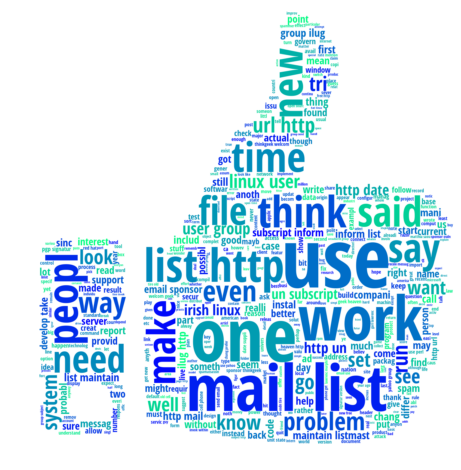

In [125]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)

rgb_array = np.array(image_mask) #Convertimos la imágen en  RGB por pixel


ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array,background_color='white',max_words=500,colormap='winter'
                      ,max_font_size=300,font_path=CUSTOM_FONT_FILE)
word_cloud.generate(ham_str)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

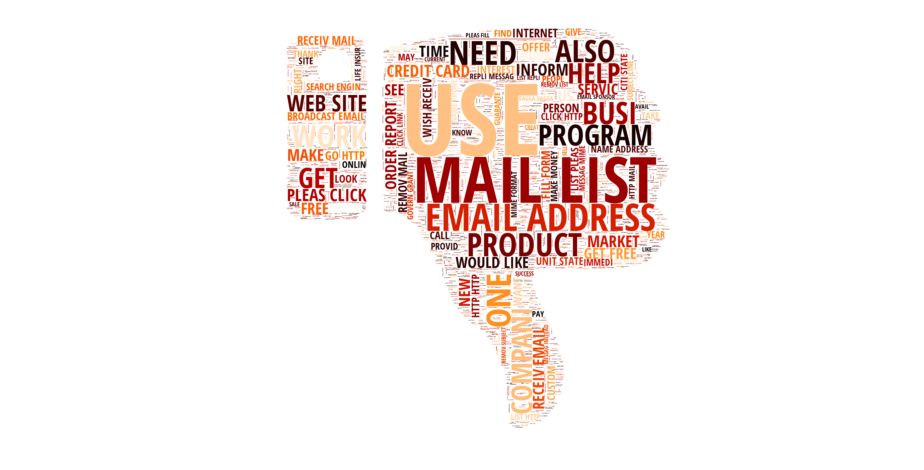

In [124]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)

rgb_array = np.array(image_mask) #Convertimos la imágen en  RGB por pixel


#Tomar nota de esto
spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array,background_color='white',max_words=2000,colormap='gist_heat'
                       ,max_font_size=300,font_path=CUSTOM_FONT_FILE)
#Tomar noota de CUSTOM FONT
word_cloud.generate(spam_str.upper())

plt.figure(figsize=[16,8])
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()


# Generate Voccabulary & Dictionary

In [133]:
#Creamos una lista con todas las palabras de los mails, sean spam o no
stemmed_nested_list = data.MESSAGE.apply(clean_message)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

In [134]:
#La convertimos en solo las unique words con value_counts()
unique_words = pd.Series(flat_stemmed_list).value_counts()

In [137]:
unique_words.head()

http     10618
use       5007
list      4823
email     4333
get       4185
dtype: int64

In [155]:
#obtenems solo las 2500 palabras más frecuentes
frequent_words = unique_words[0:VOCAB_SIZE]

In [156]:
#Top 10 palabras más frecuentes
frequent_words[:10]

http     10618
use       5007
list      4823
email     4333
get       4185
mail      3966
one       3897
free      3162
time      3083
work      2863
dtype: int64

## Create Vocabulary DataFrame with WORD_ID

In [162]:
word_ids = list(range(0,VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WOORD' : frequent_words.index.values},index=word_ids)
vocab.index.name = 'WORD_ID'

In [165]:
vocab.head()

,VOCAB_WOORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the vocabulary as CSV File

In [166]:
vocab.to_csv(WORD_ID_FIFLE,index_label=vocab.index.name, header=vocab.VOCAB_WOORD.name)

# Generate Features & Sparse Matrix
## Creating a DataFrame with one Word per Clumn

In [192]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,dear,homeown,interest,rate,lowest,point,year,help,find,best,...,None,None,None,None,None,None,None,None,None,None
1,attent,must,comput,user,packag,deal,norton,systemwork,softwar,suit,...,None,None,None,None,None,None,None,None,None,None
2,messag,mime,format,dare,tri,find,better,annuiti,guarante,year,...,None,None,None,None,None,None,None,None,None,None
3,import,inform,new,domain,name,final,avail,gener,public,discount,...,None,None,None,None,None,None,None,None,None,None
4,bottom,line,give,away,cd,free,peopl,like,one,month,...,None,None,None,None,None,None,None,None,None,None


## Splitting the Data into a Training and a Testing DataSet

In [201]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df,data.CATEGORY,test_size=0.3,random_state=42)

In [209]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,thu,jul,rodent,unusu,size,wrote,appli,one,three,order,...,None,None,None,None,None,None,None,None,None,None
4727,well,would,vaniti,list,forward,least,littl,pure,data,week,...,None,None,None,None,None,None,None,None,None,None
5022,world,wide,word,issu,saturday,august,sent,saturday,subscrib,least,...,None,None,None,None,None,None,None,None,None,None
3504,believ,spamassassin,maintain,scheme,wherebi,corpu,distribut,ie,sever,peopl,...,None,None,None,None,None,None,None,None,None,None
3921,sorri,think,send,realiz,list,sender,usual,anyawi,ask,harri,...,None,None,None,None,None,None,None,None,None,None


In [211]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

## Create a Sparse Matrix for the Training Data

In [214]:
word_index = pd.Index(vocab.VOCAB_WOORD)

In [215]:
def make_sparse_matrix(df, label, indexed_words):
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = label.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID' : doc_id, 'OCCURRENCE' : 1, 'WORD_ID' : word_id}
                dict_list.append(item)
                
    return pd.DataFrame(dict_list)

In [216]:
%%time

sparse_train_df = make_sparse_matrix(X_train,y_train,word_index)

CPU times: user 2min 38s, sys: 636 ms, total: 2min 39s
Wall time: 13min 8s


In [220]:
sparse_train_df.head()

,LABEL,DOC_ID,OCCURRENCE,WORD_ID
0,0,4844,1,395
1,0,4844,1,494
2,0,4844,1,2375
3,0,4844,1,496
4,0,4844,1,37


## Combine Ocurrances with Pandas gropuby() Method

In [232]:
train_grouped = sparse_train_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum()
#Reseteamos los indexes para que aparezca uno por row
train_grouped = train_grouped.reset_index()

In [233]:
#Redujimos el # de rows casi a la mitad
train_grouped

,DOC_ID,WORD_ID,LABEL,OCCURRENCE
0,0,0,1,2
1,0,7,1,1
2,0,15,1,1
3,0,18,1,1
4,0,24,1,1
...,...,...,...,...
264900,5795,1532,0,2
264901,5795,1884,0,1
264902,5795,1906,0,2
264903,5795,2134,0,1


## Save Training Data as .txt file

In [227]:
np.savetxt(TRAIN_DATA_FILE,train_grouped,fmt='%d')

## Repeating process for Test Data

In [234]:
#Make test Sparse Matrix
%%time

sparse_test_df = make_sparse_matrix(X_test,y_test,word_index)

CPU times: user 1min 9s, sys: 1.23 s, total: 1min 10s
Wall time: 1min 11s


In [241]:
#Group data by word occurance
test_grouped = sparse_test_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum().reset_index()
test_grouped.shape

(110143, 4)

In [247]:
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURRENCE
0,8,7,1,1
1,8,8,1,1
2,8,12,1,1
3,8,20,1,2
4,8,26,1,1


In [248]:
#Save Test Data
np.savetxt(TEST_DATA_FILE,test_grouped,fmt='%d')